<a href="https://colab.research.google.com/github/martorii/AILikesYou/blob/master/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 376 kB 34.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=692e999f0a3080dd5c96424fe9f3e3f9e5efee859f15211348615508d3218eca
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=0e682491b77829bb57d00f93601e55e9afb2a0bcd3b83d2d45ae2822bd795308
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-uatrna8i
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-uatrna8i
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 25.65 MiB/s, done.
Resolving deltas: 100% (3/3), done.


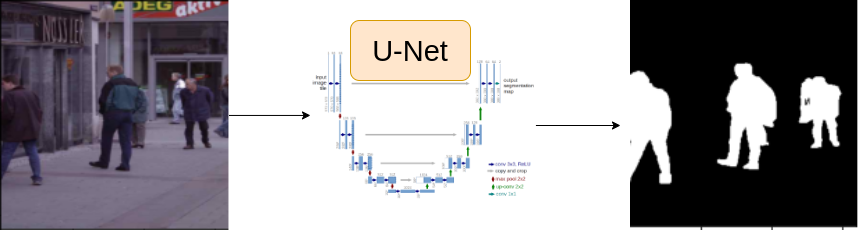

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [19]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [12]:
row = df.iloc[3]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

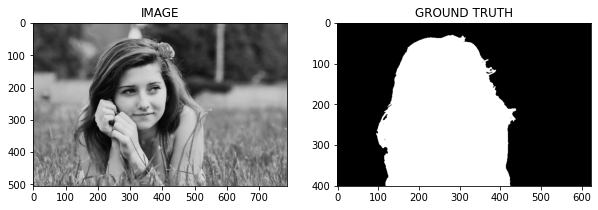

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [14]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [15]:
import albumentations as alb

In [22]:
def get_train_augs():
  return alb.Compose(
      [
        alb.Resize(IMG_SIZE, IMG_SIZE),
        alb.HorizontalFlip(p=0.5),
        alb.VerticalFlip(p=0.5)
      ]               
  )

def get_valid_augs():
  return alb.Compose(
      [
        alb.Resize(IMG_SIZE, IMG_SIZE)
      ]               
  )

# Task 4 : Create Custom Dataset 

In [23]:
from torch.utils.data import Dataset

In [28]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    # Get row from df
    row = self.df.iloc[idx]
    # Get paths to images
    image_path = row.images
    mask_path = row.masks
    # Read and convert
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Add one dimension for the channel
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis=-1)

    # Apply augmentations
    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # Convert from numpy to tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)
    return image, mask

In [29]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [30]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


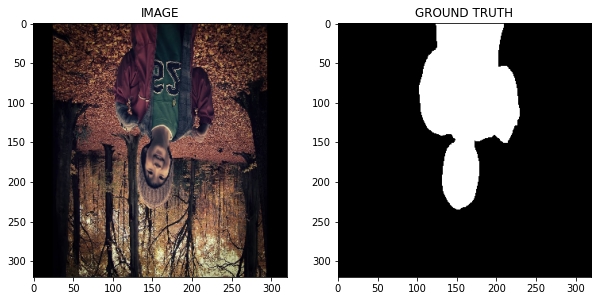

In [32]:
idx = 21
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [34]:
from torch.utils.data import DataLoader

In [35]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [36]:
print(f"total number of batches in trainloader: {len(trainloader)}")

total number of batches in trainloader: 15


In [37]:
for image, mask in trainloader:
  break
print(f"One image batch has shape: {image.shape}")
print(f"One mask batch has shape: {mask.shape}")

One image batch has shape: torch.Size([16, 3, 320, 320])
One mask batch has shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [38]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [39]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes=1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks!= None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits

In [41]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [51]:
def train_fn(data_loader, model, optimizer):
  # Set model to train mode to use Dropout layers
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


def eval_fn(data_loader, model):
  # Set mode to eval to get rid of dropouts
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [52]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [53]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED")
    best_valid_loss = valid_loss
  print(f"Epoch: {i}")
  print(f"train_loss: {train_loss}")
  print(f"valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


SAVED
Epoch: 0
train_loss: 0.4089442014694214
valid_loss: 0.33412525057792664


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


SAVED
Epoch: 1
train_loss: 0.323908927043279
valid_loss: 0.2549620270729065


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


SAVED
Epoch: 2
train_loss: 0.2646031628052394
valid_loss: 0.24158843234181404


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch: 3
train_loss: 0.274629607796669
valid_loss: 0.2516510598361492


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch: 4
train_loss: 0.1971806267897288
valid_loss: 0.2418440468609333


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


SAVED
Epoch: 5
train_loss: 0.2023807982603709
valid_loss: 0.2218734808266163


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


Epoch: 6
train_loss: 0.1863040919105212
valid_loss: 0.2911721095442772


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


SAVED
Epoch: 7
train_loss: 0.19610108733177184
valid_loss: 0.2214195691049099


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch: 8
train_loss: 0.190964038670063
valid_loss: 0.23125668615102768


100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


SAVED
Epoch: 9
train_loss: 0.20792170912027358
valid_loss: 0.19652921706438065


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch: 10
train_loss: 0.17550714562336603
valid_loss: 0.24340324848890305


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


Epoch: 11
train_loss: 0.16714474062124887
valid_loss: 0.21880292892456055


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch: 12
train_loss: 0.18578677475452424
valid_loss: 0.2937711142003536


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch: 13
train_loss: 0.18193616569042206
valid_loss: 0.21477613970637321


100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Epoch: 14
train_loss: 0.19463000893592836
valid_loss: 0.22432540729641914


100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


SAVED
Epoch: 15
train_loss: 0.1763207033276558
valid_loss: 0.18578004091978073


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]


Epoch: 16
train_loss: 0.14821301152308783
valid_loss: 0.26122067868709564


100%|██████████| 4/4 [00:01<00:00,  2.29it/s]


SAVED
Epoch: 17
train_loss: 0.13797004769245783
valid_loss: 0.1789567917585373


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


SAVED
Epoch: 18
train_loss: 0.11636815120776495
valid_loss: 0.1747644729912281


100%|██████████| 4/4 [00:01<00:00,  2.40it/s]


Epoch: 19
train_loss: 0.12200527340173721
valid_loss: 0.2514919973909855


100%|██████████| 4/4 [00:02<00:00,  1.81it/s]


Epoch: 20
train_loss: 0.14667133390903472
valid_loss: 0.20341104455292225


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


SAVED
Epoch: 21
train_loss: 0.11044282118479411
valid_loss: 0.16739487275481224


100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch: 22
train_loss: 0.10574570149183274
valid_loss: 0.18323229625821114


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


SAVED
Epoch: 23
train_loss: 0.09731216331322988
valid_loss: 0.16604369692504406


100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

Epoch: 24
train_loss: 0.12827652941147485
valid_loss: 0.17886823788285255


# Task 9 : Inference

In [55]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C, H, W) --> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

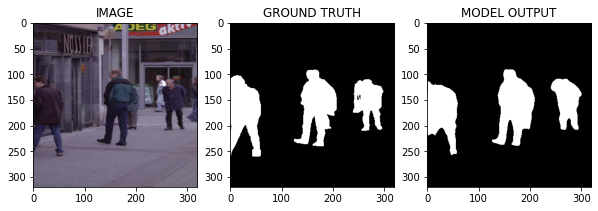

In [56]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya